
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

In [1]:
# load libraries
# %pip install mlxtend
# %pip install lightgbm

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
num_filter = 100
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
# index_name = 'record'
# y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
file_name = 'variables_400.csv'
df = pd.read_csv(file_name)


In [4]:
df.head()

,Unnamed: 0,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,...,card_state_zip_count_0_by_30,card_state_zip_count_1_by_7,card_state_zip_count_1_by_14,card_state_zip_count_1_by_30,merch_state_zip_count_0_by_7,merch_state_zip_count_0_by_14,merch_state_zip_count_0_by_30,merch_state_zip_count_1_by_7,merch_state_zip_count_1_by_14,merch_state_zip_count_1_by_30
0,0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,...,30.0,7.0,14.0,30.0,7.0,14.0,30.0,7.0,14.0,30.0
1,1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,00013,P,31.42,...,30.0,7.0,14.0,30.0,7.0,14.0,30.0,7.0,14.0,30.0
2,2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,00006,P,178.49,...,30.0,7.0,14.0,30.0,7.0,14.0,30.0,7.0,14.0,30.0
3,3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,...,30.0,7.0,14.0,30.0,7.0,14.0,30.0,7.0,14.0,30.0
4,4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,...,30.0,7.0,14.0,30.0,7.0,14.0,30.0,7.0,14.0,30.0


In [5]:
df.isnull().sum()

Unnamed: 0                       0
Recnum                           0
Cardnum                          0
Date                             0
Merchnum                         0
                                ..
merch_state_zip_count_0_by_14    0
merch_state_zip_count_0_by_30    0
merch_state_zip_count_1_by_7     0
merch_state_zip_count_1_by_14    0
merch_state_zip_count_1_by_30    0
Length: 754, dtype: int64

In [6]:
df.dtypes


Unnamed: 0                         int64
Recnum                             int64
Cardnum                            int64
Date                              object
Merchnum                          object
                                  ...   
merch_state_zip_count_0_by_14    float64
merch_state_zip_count_0_by_30    float64
merch_state_zip_count_1_by_7     float64
merch_state_zip_count_1_by_14    float64
merch_state_zip_count_1_by_30    float64
Length: 754, dtype: object

In [7]:
df.shape

(96397, 754)

In [8]:
# VT's trial
%time
filter_score_df_list = []
file_name = 'variables_400.csv'
df = pd.read_csv(file_name)
print("********** working on",file_name,"size is",df.shape)
df = df.set_index(index_name) 
 # Changed by VT, row number
df = df[df.index <= 83969] # remove the last two months as the out-of-time data (OOT)
df = df[df.index >= 3338] # remove the first 2 weeks of records since their variables aren't well formed
df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
goods = df[df[y_name] == good_label]
bads = df[df[y_name] == bad_label]
del df # don't need this file anymore
num_goods = len(goods)
num_bads = len(bads)
num_vars = len(bads.columns)-2
if(balance != 0):
    num_goods_desired = int(min(num_goods,num_bads*balance))
    goods = goods.sample(n=num_goods_desired,random_state=1)
    goods_keep = list(goods.index)
    goods_keep.sort()
'''
    if(i > 0):
        goods = goods.loc[goods_keep] '''

df_sampled = pd.concat([goods,bads])
df_sampled.sort_index(inplace=True)
filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
filter_score.columns = ['variable','score']   
j = 0
for column in df_sampled:
    filter_score.loc[j,'variable'] = column
    filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
    j = j+1
    if j%100 == 0:
        print(j)

filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][1:num_filter+1]) 
print(file_name,filter_score.head(20))
#if(i == 0): # if first time through need to initialize some stuff
Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
df_top = df_sampled.filter(vars_keep, axis=1)
''''
if(i > 0): # if more than one variable file we use this loop
    data_new_top = df_sampled.filter(vars_keep, axis=1)
    df_top = pd.concat([df_top,data_new_top], axis=1)


Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
'''
#     filter_score = pd.concat([filter_score,new])
filter_score_df_list.append(filter_score)

del goods # delete these before starting the next file, if any
del bads
gc.collect()
filter_score = pd.concat(filter_score_df_list)

Wall time: 0 ns
********** working on variables_400.csv size is (96397, 754)
100
200
300
400
500
600
700
variables_400.csv                       variable     score
9                        Fraud  1.000000
548   card_merch_state_total_7  0.681937
218         card_merch_total_7  0.681685
328           card_zip_total_7  0.676814
557  card_merch_state_total_14  0.676342
227        card_merch_total_14  0.675876
539   card_merch_state_total_3  0.675866
209         card_merch_total_3  0.675753
264         card_state_total_3  0.674682
603     card_state_zip_total_7  0.672350
493     card_merch_zip_total_7  0.672274
319           card_zip_total_3  0.670655
273         card_state_total_7  0.669826
282        card_state_total_14  0.668904
594     card_state_zip_total_3  0.667393
484     card_merch_zip_total_3  0.667330
612    card_state_zip_total_14  0.665967
502    card_merch_zip_total_14  0.665803
337          card_zip_total_14  0.661991
566  card_merch_state_total_30  0.660084


In [9]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [10]:
filter_score.head(60)

,variable,score
9,Fraud,1.000000
548,card_merch_state_total_7,0.681937
218,card_merch_total_7,0.681685
328,card_zip_total_7,0.676814
557,card_merch_state_total_14,0.676342
227,card_merch_total_14,0.675876
539,card_merch_state_total_3,0.675866
209,card_merch_total_3,0.675753
264,card_state_total_3,0.674682
603,card_state_zip_total_7,0.672350


In [11]:
filter_score.to_csv('filter_score.csv')

In [12]:
filter_score.tail(10)

,variable,score
707,card_state_count_0_by_30,0.075582
713,card_zip_count_0_by_30,0.074057
714,card_zip_count_1_by_7,0.072544
703,card_merch_count_1_by_14,0.059256
739,card_merch_state_count_1_by_14,0.059237
733,card_merch_zip_count_1_by_14,0.059049
745,card_state_zip_count_1_by_14,0.058633
708,card_state_count_1_by_7,0.054669
753,RANDOM,0.028958
7,Transtype,0.000000


In [13]:
filter_score.shape

(754, 2)

In [14]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(' vars_keep:',vars_keep)

 vars_keep: ['card_merch_state_total_7', 'card_merch_total_7', 'card_zip_total_7', 'card_merch_state_total_14', 'card_merch_total_14', 'card_merch_state_total_3', 'card_merch_total_3', 'card_state_total_3', 'card_state_zip_total_7', 'card_merch_zip_total_7', 'card_zip_total_3', 'card_state_total_7', 'card_state_total_14', 'card_state_zip_total_3', 'card_merch_zip_total_3', 'card_state_zip_total_14', 'card_merch_zip_total_14', 'card_zip_total_14', 'card_merch_state_total_30', 'card_state_total_1', 'card_merch_total_30', 'card_merch_state_total_1', 'card_merch_total_1', 'card_merch_state_max_14', 'card_zip_total_1', 'card_merch_max_14', 'card_merch_state_max_7', 'card_merch_state_max_30', 'card_merch_max_7', 'card_merch_max_30', 'card_state_zip_total_1', 'card_merch_zip_total_1', 'card_state_zip_total_30', 'card_merch_zip_total_30', 'card_zip_max_7', 'card_state_max_3', 'card_zip_max_14', 'card_zip_total_30', 'card_state_max_7', 'card_state_zip_max_14', 'card_merch_zip_max_14', 'card_mer

In [15]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_merch_state_total_7,card_merch_total_7,card_zip_total_7,card_merch_state_total_14,card_merch_total_14,card_merch_state_total_3,card_merch_total_3,card_state_total_3,card_state_zip_total_7,card_merch_zip_total_7,...,card_merch_avg_30,card_merch_state_avg_30,merch_zip_total_1,card_merch_zip_avg_7,card_state_zip_avg_7,card_state_zip_avg_3,card_merch_zip_avg_3,merch_state_max_1,card_merch_avg_3,card_merch_state_avg_3
Recnum,,,,,,,,,,,,,,,,,,,,,
3338,150.75,150.75,150.75,150.75,150.75,150.75,150.75,516.83,150.75,150.75,...,75.375,75.375,36.9,75.375,75.375,75.375,75.375,36.9,75.375,75.375
3339,590.00,590.00,590.00,590.00,590.00,590.00,590.00,590.00,590.00,590.00,...,590.000,590.000,590.0,590.000,590.000,590.000,590.000,590.0,590.000,590.000
3340,120.00,120.00,120.00,120.00,120.00,120.00,120.00,466.28,120.00,120.00,...,120.000,120.000,120.0,120.000,120.000,120.000,120.000,120.0,120.000,120.000
3341,545.00,545.00,545.00,545.00,545.00,545.00,545.00,545.00,545.00,545.00,...,545.000,545.000,545.0,545.000,545.000,545.000,545.000,545.0,545.000,545.000
3342,6576.00,6576.00,6576.00,6576.00,6576.00,6576.00,6576.00,6576.00,6576.00,6576.00,...,1315.200,1315.200,27442.5,1315.200,1315.200,1315.200,1315.200,2500.0,1315.200,1315.200


In [16]:
df_keep.shape

(80309, 100)

In [17]:
Y.head()

,Fraud
Recnum,
3338,0
3339,0
3340,0
3341,0
3342,0


In [18]:
Y = Y.values
Y_save = Y.copy()

In [19]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [20]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:02:02.487183


In [21]:
print(X.shape,Y.shape)

(80309, 100) (80309, 1)


In [22]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [23]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [24]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=10,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished

[2022-05-05 14:47:26] Features: 1/20 -- score: 0.6125233894680566[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished

[2022-05-05 14:48:38] Features: 2/20 -- score: 0.665624164661855[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  1.2min finished

[2022-05-05 14:49:49] Features: 3/20 -- score: 0.6621758887997862[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  97 out of

Wall time: 42min 12s



[2022-05-05 15:28:30] Features: 20/20 -- score: 0.6737236033146218

SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=3),
                          k_features=20, n_jobs=-1,
                          scoring=<function fdr at 0x0000028EFFC980D0>,
                          verbose=2)

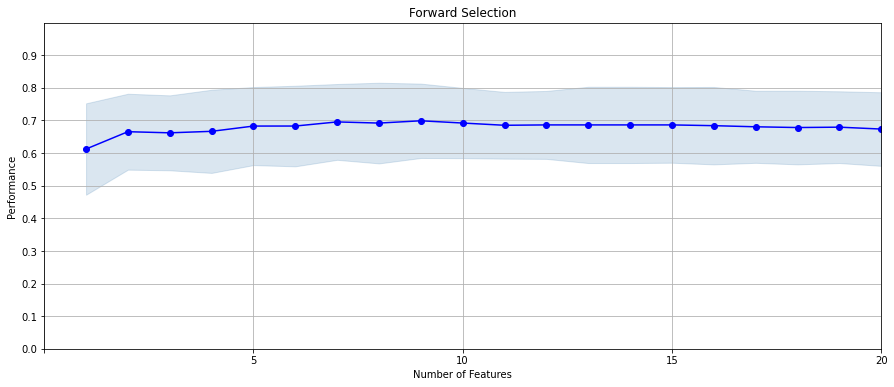

In [25]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Forward Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [26]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [27]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])

In [28]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(0,)","[0.4418604651162791, 0.5747126436781609, 0.747...",0.612523,"(card_merch_total_7,)",0.104053,0.140098,0.046699,1.0,card_merch_total_7
2,"(0, 17)","[0.6395348837209303, 0.5517241379310345, 0.747...",0.665624,"(card_merch_total_7, card_state_max_3)",0.086449,0.116397,0.038799,2.0,card_state_max_3
3,"(0, 17, 38)","[0.6395348837209303, 0.5517241379310345, 0.689...",0.662176,"(card_merch_total_7, card_state_max_3, Merchnu...",0.085327,0.114886,0.038295,3.0,Merchnum_max_0
4,"(0, 17, 22, 38)","[0.6395348837209303, 0.5517241379310345, 0.758...",0.666774,"(card_merch_total_7, card_state_max_3, card_zi...",0.0947,0.127506,0.042502,4.0,card_zip_max_3
5,"(0, 17, 22, 38, 43)","[0.5581395348837209, 0.5632183908045977, 0.747...",0.682892,"(card_merch_total_7, card_state_max_3, card_zi...",0.088857,0.119638,0.039879,5.0,Cardnum_total_7
6,"(0, 17, 22, 38, 43, 78)","[0.6511627906976745, 0.5517241379310345, 0.689...",0.682986,"(card_merch_total_7, card_state_max_3, card_zi...",0.091745,0.123526,0.041175,6.0,merch_state_max_3
7,"(0, 17, 22, 38, 43, 78, 97)","[0.6511627906976745, 0.5517241379310345, 0.689...",0.69563,"(card_merch_total_7, card_state_max_3, card_zi...",0.086329,0.116234,0.038745,7.0,Merchnum_max_3
8,"(0, 17, 22, 35, 38, 43, 78, 97)","[0.5581395348837209, 0.5517241379310345, 0.747...",0.692074,"(card_merch_total_7, card_state_max_3, card_zi...",0.091849,0.123667,0.041222,8.0,merch_state_max_0
9,"(0, 17, 22, 35, 38, 43, 64, 78, 97)","[0.6511627906976745, 0.5517241379310345, 0.747...",0.699078,"(card_merch_total_7, card_state_max_3, card_zi...",0.084666,0.113995,0.037998,9.0,Merchnum_max_1
10,"(0, 1, 17, 22, 35, 38, 43, 64, 78, 97)","[0.6511627906976745, 0.5517241379310345, 0.701...",0.692181,"(card_merch_total_7, card_zip_total_7, card_st...",0.079984,0.107692,0.035897,10.0,card_zip_total_7


In [29]:
ordered_vars_FS.to_csv('VarsFS-1.csv', index=False)

In [30]:
ordered_vars_FS['variable name']

1          card_merch_total_7
2            card_state_max_3
3              Merchnum_max_0
4              card_zip_max_3
5             Cardnum_total_7
6           merch_state_max_3
7              Merchnum_max_3
8           merch_state_max_0
9              Merchnum_max_1
10           card_zip_total_7
11            merch_zip_max_1
12              Cardnum_max_0
13              Cardnum_avg_1
14              Cardnum_avg_0
15          merch_state_max_1
16            merch_zip_max_0
17            merch_zip_max_3
18    Merch description_max_3
19    Merch description_max_0
20    Merch description_max_1
Name: variable name, dtype: object

In [31]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)

In [32]:
vars_keep

1          card_merch_total_7
2            card_state_max_3
3              Merchnum_max_0
4              card_zip_max_3
5             Cardnum_total_7
6           merch_state_max_3
7              Merchnum_max_3
8           merch_state_max_0
9              Merchnum_max_1
10           card_zip_total_7
11            merch_zip_max_1
12              Cardnum_max_0
13              Cardnum_avg_1
14              Cardnum_avg_0
15          merch_state_max_1
16            merch_zip_max_0
17            merch_zip_max_3
18    Merch description_max_3
19    Merch description_max_0
20    Merch description_max_1
Name: variable name, dtype: object

In [33]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_merch_total_7',
 'card_state_max_3',
 'Merchnum_max_0',
 'card_zip_max_3',
 'Cardnum_total_7',
 'merch_state_max_3',
 'Merchnum_max_3',
 'merch_state_max_0',
 'Merchnum_max_1',
 'card_zip_total_7',
 'merch_zip_max_1',
 'Cardnum_max_0',
 'Cardnum_avg_1',
 'Cardnum_avg_0',
 'merch_state_max_1',
 'merch_zip_max_0',
 'merch_zip_max_3',
 'Merch description_max_3',
 'Merch description_max_0',
 'Merch description_max_1',
 'Recnum',
 'Fraud']

In [34]:
df = pd.read_csv(file_name)

In [35]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(96397, 22)


In [36]:
df_keep.to_csv('vars_final_1.csv',index=False)

In [37]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:42:51.523234
